# Intro Call Scoring Model - Exploratory Data Analysis

Goals of the project:
    
    1) Determine if correlations between key sales indicators (account level demographics, lead characteritics, etc) and qualification/deal oppty exist.
    
    2) Is there a statistically significant difference between qualified and disqualified intro calls in regards to information given?
    
    3) Create machine learning model that allows us to predict whether an introcall will be qualified, whether opportunity will result, and the value of the resulting opportunity. Look at important features as well.

In [1]:
import psycopg2
from sqlalchemy.engine import url as sa_url
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np
import datetime
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
#function to clean dates
def clean_dates(df, oldColName, newColName, timedatepattern):
    """This will take a dataframe, a number of column names & create new columns of datetime objects"""
    emptyDateFrame = []
    colPosition = len(df.columns)
    for date in df[oldColName]:
        if date != None:
                if pd.isna(date):
                        emptyDateFrame.append(np.nan)
                else:        
                        if isinstance(date, str):
                                emptyDateFrame.append(datetime.datetime.strptime(date, timedatepattern))
                        else:
                                emptyDateFrame.append(datetime.datetime.strptime(str(date), timedatepattern))
        else:
            emptyDateFrame.append(None)
    df.insert(colPosition, newColName, emptyDateFrame)
    del df[oldColName]
    return df

In [3]:
#function to rempa values based on provded dicts
def clean_map(df, dictToMap, oldColName):
    """This will take a dataframe, 
    a number of column names & 
    create new columns of datetime objects"""
    newColName = oldColName + "_map"
    df[newColName] = df[oldColName].map(dictToMap) 
    del df[oldColName]
    return df


In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [5]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.abs(np.mean(data_1) - np.mean(data_2))
    newDiff = diff.item()

    return newDiff

In [6]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [7]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return np.array(perm_replicates)

In [8]:
def draw_perm_reps_with_ecdf(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        _=i
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        
         # Compute ECDFs
        x_1, y_1 = ecdf(perm_sample_1)
        x_2, y_2 = ecdf(perm_sample_2)

        # Plot ECDFs of permutation sample
        _ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
        _ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)


        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return np.array(perm_replicates), _

In [9]:
def bootstrap_replicate_1d(data, func):
   # print(type(data))
   # print(data.shape)
    replicatedArray = np.random.choice(data.flatten(), size=len(data))
    return func(replicatedArray)

In [10]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] =  bootstrap_replicate_1d(data,func)  

    return bs_replicates

engine = create_engine('redshift+psycopg2://username@host.amazonaws.com:5439/database')

In [11]:
##Create the database connection to the company database
#db_connect_url = sa_url.URL(

#)
#engine = create_engine(db_connect_url)
#con = engine.connect()


##Ensure connection to the right schemas within the tables within the database
#session = sessionmaker()
#session.configure(bind=engine)
#s = session()
#SetPath = "SET search_path TO %s" % 'ods'
#s.execute(SetPath)

In [12]:
## Query vis SQL Aclhemy th Leads and Introcalls tables to create the lead scoring table

#leads_query = "Select * from sf_lead"
#rs = s.execute(leads_query)
#leads_raw = pd.DataFrame(rs.fetchall())
#leads_raw.columns = rs.keys()


#pd.DataFrame(leads_raw.head(50)).to_csv('leads_sample.csv')
#leads_raw.to_csv('leads_full_data.csv')
leads_raw = pd.read_csv('leads_full_data.csv')

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,64,66,72,73,74,75,78,79,83,84,89,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
##Intro Calls
#intro_calls_query = "Select * from sf_intro_call__c"
#rs = s.execute(intro_calls_query)
#intro_calls_raw = pd.DataFrame(rs.fetchall())
#intro_calls_raw.columns = rs.keys()

#pd.DataFrame(intro_calls_raw.head(50)).to_csv('intro_calls_sample.csv')
#intro_calls_raw.to_csv('intro_calls_full_data.csv')
intro_calls_raw = pd.read_csv('intro_calls_full_data.csv')

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (85,93,107,109,113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
#s.close()
#con.close()

# Data Description

In [15]:
# Lead Data
print("___________________________________Summary on Leads Object___________________________________")
print("Leads Raw Info:", leads_raw.info())
print("Leads Raw Count:", leads_raw.count())
lead_raw_list = list(leads_raw.columns)

#Intro Call Data
print("___________________________________Summary on Intro Calls Object___________________________________")
print("Intro Call Raw Info:",intro_calls_raw.info())
print("Intro Call Raw Count:",intro_calls_raw.count())
intro_calls_raw_list = list(intro_calls_raw.columns)

___________________________________Summary on Leads Object___________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493767 entries, 0 to 493766
Columns: 108 entries, Unnamed: 0 to clearbit_employees__c
dtypes: bool(17), float64(5), int64(2), object(84)
memory usage: 350.8+ MB
Leads Raw Info: None
Leads Raw Count: Unnamed: 0                            493767
id                                    493767
isdeleted                             493767
masterrecordid                            32
lastname                              491233
firstname                             381490
salutation                              6181
name                                  493519
title                                 292855
company                               492978
street                                 67935
city                                  427036
state                                 250352
postalcode                             61654
country                    

In [16]:
# Fields to Use for master data set
lead_fields_masterDataSet =['email','firstname','lastname','title','customer_type__c','company','street','city','state','country','linkedin_page__c','traffic_channels__c','marketing_channel_campaign_name__c','landing_page__c','landing_page_url__c','google_campaign__c','leadsource','converteddate','status_reason__c','status','id','convertedaccountid','convertedcontactid','convertedopportunityid','ownerid','createdbyid','createddate','duplicate_lead__c','isconverted','isdeleted','pitch__c','infer3__infer_score__c','total_calls__c','total_emails__c','users_amount__c','marketing_camp_id__c','marketing_channel_ad_id__c','of_employees_category__c']
intro_call_fields_masterDataSet = ['id','lead_name__c','related_account__c','related_opportunity__c','ownerid','contact__c','assigned_to__c','assigned_to_role__c','name','createdbyid','createddate','isdeleted','meeting_status__c','lead_status__c','qualification_date__c','qualified_without_opp_reason_other__c','qualified_without_opportunity_reason__c','rejected_other_reason__c','rejected_reason__c','rescheduled__c','rescheduled_from_intro_call__c','no_show_other_reason__c','no_show_reason__c','additional_user_information__c','meeting_comments__c','sales_comments__c','use_cases_pains__c','customer_employee_facing__c','decision_maker_picklist__c','double_dipper__c','project_due_quarter_fiscal__c','product__c','product_s__c','application_type__c','new_existing_customer__c','intro_call_source_marketing_outbound__c','recordtypeid','created_day_of_the_week__c']

## Data Joining

In [17]:
# Isolate out the desired data to combine
leads_join_masterDataSet = leads_raw[lead_fields_masterDataSet]
intro_call_join_masterDataSet = intro_calls_raw[intro_call_fields_masterDataSet]


In [18]:
# Rename Columns
leads_join_masterDataSet.columns = ['email___Lead_PersonalInformation','firstname___Lead_PersonalInformation','lastname___Lead_PersonalInformation','title___Lead_PersonalInformation','customerType___Lead_LeadCompanyInformation','company___Lead_LeadCompanyInformation','street___Lead_LeadCompanyInformation','city___Lead_LeadCompanyInformation','state___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','trafficChannel___Lead_MarketingInformation','mktChannelcampaign___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','landingPageUrl___Lead_MarketingInformation','googleCampaign___Lead_MarketingInformation','leadsource___Lead_MarketingInformation','converteddate___Lead_ConversionInformation','statusReason___Lead_ConversionInformation','status___Lead_ConversionInformation','PK_LeadID___Lead_ImportantJoinKey','FK_LeadtoAccount___Lead_ImportantJoinKey','FK_LeadtoContact___Lead_ImportantJoinKey','FK_LeadtoOpportunity___Lead_ImportantJoinKey','FK_LeadtoUser___Lead_ImportantJoinKey','createdbyid___Lead_ImportantSystemInfo','createddate___Lead_ImportantSystemInfo','duplicateLead___Lead_ImportantSystemInfo','isconverted___Lead_ImportantSystemInfo','isdeleted___Lead_ImportantSystemInfo','pitch___Lead_AddedInfo','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','marketingCampaignID___Lead_AddedInfo','marketingChannelAdID___Lead_AddedInfo','employeeCategory___Lead_AddedInfo']
intro_call_join_masterDataSet.columns = ['PK_IntroCall_ID___IntroCall_ImportantIDInfo','FK_IntroCalltoLead___IntroCall_ImportantJoinKey','FK_IntroCalltoAccount___IntroCall_ImportantJoinKey','FK_IntroCalltoOppty___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoContacts___IntroCall_ImportantJoinKey','assignedToRole___IntroCall_OtherInfo','name___IntroCall_OtherInfo','createdbyid___IntroCall_ImportantSystemInfo','createddate___IntroCall_ImportantSystemInfo','isdeleted___IntroCall_ImportantSystemInfo','Target___IntroCall_Outcome','leadStatus___IntroCall_Outcome','qualDate___IntroCall_Outcome','qualWithoutOppReason1___IntroCall_Outcome','qualWithoutOppReason2___IntroCall_Outcome','rejectedOtherReason___IntroCall_Outcome','rejectedReason___IntroCall_Outcome','rescheduled___IntroCall_Outcome','rescheduledFromIntroCall___IntroCall_Outcome','noShowReason2___IntroCall_Outcome','noShowReason1___IntroCall_Outcome','addUserInfo___IntroCall_MeetingDetails','meetingComments___IntroCall_MeetingDetails','salesComments___IntroCall_MeetingDetails','useCases___IntroCall_MeetingDetails','customerOrEmployee___IntroCall_MeetingDetails','decisionMaker___IntroCall_MeetingDetails','doubleDipper___IntroCall_MeetingDetails','projectDueQ___IntroCall_MeetingDetails','produce1___IntroCall_MeetingDetails','product2___IntroCall_MeetingDetails','appType___IntroCall_MeetingDetails','newOrExistingCustomer___IntroCall_LeadInformation','introCallMktSource___IntroCall_LeadInformation','recordtypeid___IntroCall_LeadInformation','createdDayOFWeek___IntroCall_AddedInfo']

In [19]:
# Left Join Lead to Intro Call via Intro Call's lead_name_c and Lead's convertedopportunityid

masterDataSet = pd.merge(intro_call_join_masterDataSet,leads_join_masterDataSet, how='left', left_on=['FK_IntroCalltoLead___IntroCall_ImportantJoinKey'],right_on=['PK_LeadID___Lead_ImportantJoinKey'])


In [20]:
#Making a copy - original safe keeping
masterDataSetCopy = masterDataSet.copy()

masterDataSetCopy.to_csv('masterDataSet_LeadsIntroCalls_copy.csv')

In [21]:
#DateTime Cleaning
#masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'qualDate___IntroCall_Outcome','qualDate___IntroCall_Outcome_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'converteddate___Lead_ConversionInformation', 'converteddate___Lead_ConversionInformation_clean','%Y-%m-%d')

#Because of the odd formatting that occasionally comes out of Salesforce we need to take the first 10 characters before the 'tz' denotation
masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'].str[:10]
masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'].str[:10]

masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___Lead_ImportantSystemInfo', 'createddate___Lead_ImportantSystemInfo_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___IntroCall_ImportantSystemInfo', 'createddate___IntroCall_ImportantSystemInfo_clean','%Y-%m-%d')


In [22]:
# Time Deltas

masterDataSetCopy_dateTimeTest['introCallCreated_leadCreated_delta'] = (masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean'] - masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo_clean']).dt.days
#masterDataSetCopy_dateTimeTest['qualDate_introCallDate_delta'] = (masterDataSetCopy_dateTimeTest['qualDate___IntroCall_Outcome_clean'] - masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean']).dt.days


In [23]:
#use dictionaries to regroup values

Target___IntroCall_Outcome_dict={"Attributed":1,"Cancelled":0,"No Show":0,"Qualified":1,"Rejected":0,"Rescheduling":-1,"Scheduled":-1}
rejectedReason___IntroCall_Outcome_dict={"Company Too Small":"Wrong_Demographic","Does Not See Benefit of WalkMe":"Not_Interested","Existing Opportunity":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Not_Right_Person","Not A Use Case Fit":"Not_Interested","Not Decision Maker":"Not_Right_Person","Other (please specify)":"Other","Project Fully Outsourced":"Other","Startup - Too Expensive":"Price_Too_High","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Other","Wrong Timing":"Not_Interested","__":"Other"}
status___Lead_ConversionInformation_dict={"Cancelled":0,"Conference Rejuvenated":-1,"Contacted":0,"Converted":1,"Engaged":-1,"Finished Sequence":-1,"Junk":0,"Moved to SE":-1,"No Show":0,"No longer with company":0,"Not Relevant":0,"Nurture":-1,"Nurture (Outbound)":-1,"Open":-1,"Prospecting":-1,"Qualified":1,"Rejected":0,"Rejuvenated":-1,"SBC - Rejected":0,"SE Qualified":1,"SE Rejected":0,"Scheduled":-1,"Sent to Partner":0,"Unqualified":0}
trafficChannel___Lead_MarketingInformation_dict={"Organic SEO":"SEO","Affiliate":"Affiliate","Banner":"Other","Bing":"Bing","Biz Dev":"Other","BizoLi":"Other","Brand":"Brand","Bulk upload - R&D's bug":"Other","Conference Emails":"Email","Conferences":"Event/Conference","Conferences Lead Swaps":"Event/Conference","Customer Engagement Event":"Event/Conference","Email Nurturing":"Email","Email Nurturing Conferences":"Email","EmailMarketing":"Email","EmailNurturing":"Email","External":"Event/Conference","External Conferences":"Event/Conference","Facebook":"Facebook","FootPrints":"Other","LinkedIn":"LinkedIn","Live Chat":"Other","Media":"Other","Outbound":"Outbound","Partner":"Partner","Partner Outbound":"Partner","Ppc":"PPC","Raj List":"Other","RefererType11":"Other","RefererType12":"Other","RefererType18":"Other","RefererType20":"Other","RefererType5":"Other","RefererType6":"Other","RefererType7":"Other","RefererType8":"Other","RefererType9":"Other","SearchEngine":"Search","Site Banners":"Site Banner","Site Banners2":"Site Banner","SiteBanners":"Site Banner","SiteBanners2":"Site Banner","Social Traffic":"Other","Super Tools":"Other","TestCampaign":"Other","TrafficChannel":"Other","Twitter":"Twitter","Unknown":"Unknown","Unomi":"Other","Unomy - Strategic":"Other","User":"User","WalkMe Blog":"Blog","WebsiteLink":"Website","Youtube":"Youtube","sfEdit":"Other","unomy":"Other"}
stagename___Oppty_CloseInformation_dict={"1 - Contacted":"Open","2 - Demo 1":"Open","3 - POC setup":"Open","3 - Working":"Open","4 - Free POC in Progress":"Open","4 - POC \ Reselling Value":"Open","5 - Proposal/Price Quote":"Open","6 - Negotiation/Review":"Open","7 - Verbal Agreement":"Open","8 - Closed Won":"Closed Won","9 - Business Lost":"Closed Lost","9- Duplicate Opportunity":"Duplicate"}
statusReason___Lead_ConversionInformation_dict={"Already customer":"Duplicate","Bad Contact Info":"Bad_Data","Company Too Small":"Wrong_Demographic","DM Title":"Good_Fit","Desktop":"Other","Duplicate":"Duplicate","Existing Opportunity":"Duplicate","Interested":"Good_Fit","Interviewing":"Good_Fit","Language":"Other","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Wrong_Demographic","No DM":"Not_Right_Person","No Interest":"Not_Interested","No Phone Number":"Bad_Data","No project":"Not_Interested","No response":"Not_Interested","No/Bad Phone Number":"Bad_Data","Not Decision Maker":"Not_Right_Person","Not Relevant":"Wrong_Demographic","Not enough users":"Wrong_Demographic","Not enough users - External":"Wrong_Demographic","Not enough users - Internal":"Wrong_Demographic","Nurture - Bad Contact Info":"Bad_Data","Nurture - Opt Out":"Not_Interested","Nurture - Replied":"Not_Interested","Nurture - Unresponsive":"Not_Interested","Other":"Other","Other (please specify)":"Other","Personal Use":"Wrong_Demographic","Price":"Price_Too_High","Source Version":"Good_Fit","Startup - Too Expensive":"Price_Too_High","Timing":"Good_Fit","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Wrong_Demographic","Wrong Timing":"Wrong_Demographic"}
blReason___Oppty_CloseInformation_dict={"Competition":"Competition","Didn't See Product Value":"Not_Interested","Dissapeared":"Not_Interested","Duplicate":"Duplicate","Merged":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Decision Maker":"Not_Right_Person","No Interest":"Not_Interested","Other":"Other","Product Not Working":"Product","Project Postponed":"Other","Project Postponed / Cancelled":"Other","Security or Compliance Issues":"Other","System Too Small":"Wrong_Demographic","Too Few Users":"Wrong_Demographic"}

#issues remapping this
#landingPage___Lead_MarketingInformation_dict={"/cx-corporate-5-provide-ultimate-experience":"CX","/elearning-1":"E_Learning","172594":"Other","416863":"Other","416883":"Other","416913":"Other","773984":"Other","809853":"Other","809923":"Other","809963":"Other","919723":"Other","98-customer-satisfaction":"Other","Acumatica":"Other","Concur":"Concur","EmpTraining":"Other","Epicor-Software":"Epicor","General":"Other","HomePageRequestDemo":"Request Demo","IBM-Smarter-workspace":"IBM","IBM-WebSphere2":"IBM","Instantly-UX":"UX","Omri-SF2":"Salesforce","Omri-SF2-sales-f-training":"Salesforce","Omri-SF2-sf.comtrainig":"Salesforce","Omri-SF2-sfdctraining":"Salesforce","Omri-SF2-sftraining":"Salesforce","PartnerRegPage":"Partner","Pegasystems":"Pegasystems","PeopleSoft":"Peoplesoft","Popup":"Popup","QuickBase":"QuickBase","SAP-HANA":"SAP","SAP-cloud":"SAP","SF-easier":"Salesforce","SF-never-easier":"Salesforce","Sharepoint":"Sharepoint","Sharepoint-tra":"Sharepoint","UX-Main":"UX","UXlp":"UX","[land]":"UX","absolute-sharepoint":"Sharepoint","adoption-corporate-1-ensure-successful":"Adoption Corporate","adoption-corporate-1-ensure-successful-adoption":"Adoption Corporate","adoption-corporate-2-software-simplify":"Adoption Corporate","adoption-corporate-3-ensure-successful-2":"Adoption Corporate","adoption-corporatelogo-3-software":"Adoption Corporate","adoption-walkmeblog-corporate-006-i":"Adoption","adoption_hris":"Adoption","adp-onboarding-2":"ADP","adp-onboarding/":"ADP","advfeatures":"other","ariba":"Ariba","ariba-corporate-1-simplify-training":"Ariba","ariba-corporate-1-using-never-easier":"Ariba","ariba-training":"Ariba","ariba-training-no-logos":"Ariba","ariba-training-wm":"Ariba","ariba-tutorial-wm":"Ariba","better-ux-wm-2-tw":"UX","better-ux-wm-3":"UX","cac":"Other","change":"Change Corporate","change-04":"Change Corporate","change-04/":"Change Corporate","change-corporate-1":"Change Corporate","change-corporate-1-experience-simple-change":"Change Corporate","change-corporate-1-gif":"Change Corporate","change-corporate-1-management-has-never-easier":"Change Corporate","change-corporate-1-management-never-been-easier":"Change Corporate","change-corporate-2-enterprise-change-management":"Change Corporate","change-corporate-2-enterprise-change-management/":"Change Corporate","change-corporate-3-discover-how-easy-can-be":"Change Corporate","change-corporate-3-experience-simple-change":"Change Corporate","change-corporate-4-experience-simple-change":"Change Corporate","change-corporate-4-make-management-easier-than-ever":"Change Corporate","change-employee-engagement":"Change Employee Engagement ","change-management-bl-2":"Change Management","change-management-bl-2-demo":"Change Management","change-management-easy-wm":"Change Management","change-management-lp":"Change Management","change-management-lp-wm":"Change Management","change-management-software-2":"Change Management","change-management-tools":"Change Management","change-notify":"Change Management","change-s":"Change Management","change-walkmeblog-corporate-000-o":"Change Management","change-wt-1-make-enterprise-management-easy-and-effective":"Change Management","change-wt-3-make-enterprise-management-easy-effective":"Change Management","change-wt-3-make-enterprise-management-easy-effective/":"Change Management","change03":"Change Management","change04":"Change Management","changemanagementsolution":"Change Management","cio-1":"CIO","cio-2b":"CIO","cio-2b-tw":"CIO","cio-2b-wm":"CIO","cio-3":"CIO","cio-corporate-1-being-cio-is-not-simple":"CIO","cio-corporate-1-simplify-adoption":"CIO","cio-corporate-1-simplify-software-adoption":"CIO","cio-useradoption-simplify":"CIO","cio-useradoption-simplify-software":"CIO","cio-wt-1-cio-isnt-simple":"CIO","cio-wt-1-isnt-simple":"CIO","cnf-df16":"Other","cnf-mi":"Other","competence":"Concur","concur-cv-1-boost-training":"Concur","concur-training":"Concur","concur-training-boost":"Concur","concur-tutorial":"Concur","concur-user-onboarding":"Concur","concur-user-onboarding-1":"Concur","concur-user-onboarding-2-2":"Concur","contact":"Other","convergence2014":"Other","cornerstone-migration":"Other","coupa-corporate-5-never-easier":"Coupa","coupa-easier-wm":"Coupa","coupa-onboarding-wm":"Coupa","create-the-ultimate-demo-with-walkme":"Create Demo","createtutorials":"Create Tutorials","creating-online-tutorials":"Create Tutorials","creating-online-tutorials-fr":"Create Tutorials","creating-online-tutorials-three-fields":"Create Tutorials","creating-online-tutorials-wm":"Create Tutorials","creating-online-tutorials/":"Create Tutorials","crm":"CRM","crm-get-the-most":"CRM","crm-learning":"CRM","crm-training":"CRM","crm-tutorials":"CRM","crmlp":"CRM","cserv1":"Other","cts-s":"CTS","cust-engagment":"CustomerEngagement_Stories","customer-experience-achieve":"CustomerEngagement_Stories","customer-stories":"CustomerEngagement_Stories","customer-stories-bing-ads":"CustomerEngagement_Stories","customer-stories-db-schenker":"CustomerEngagement_Stories","cx-corporate-1-10x-better":"CX_Corporate","cx-corporate-1-achieve-best":"CX_Corporate","cx-corporate-1-achieve-best-customer-experience":"CX_Corporate","cx-corporate-1-instantly-optimize-customer-experience":"CX_Corporate","cx-corporate-1-provide-the-ultimate-experience-cartoon":"CX_Corporate","cx-corporate-3-customer-journey-map":"CX_Corporate","cx-corporate-4-online-customer-experience-better-than-ever":"CX_Corporate","cx-corporate-4-online-customer-experience-better-than-ever=Adoption-Promotion":"CX_Corporate","cx-corporate-5-achieve-best":"CX_Corporate","cx-corporate-5-easily-manage-cx":"CX_Corporate","cx-corporate-5-optimize-customer-experience":"CX_Corporate","cx-corporate-5-optimize-customer-experience-cartoon":"CX_Corporate","cx-corporate-5-provide-ultimate-experience-cartoon":"CX_Corporate","cx-digital-experience":"CX_Corporate","cx-walkmeblog-corporate-008-q":"CX_Corporate","cx-walkmeblog-plainwhite-000-p":"CX_Corporate","dap-corporate-2-discover-walkme":"DAP","dap-corporate-2-worlds-first-adoption-flatform":"DAP","dap-cv-2-help-users-engage-technology":"DAP","dap-wta-1-make-technology-work-organization":"DAP","demo-corporate-1-create-ultimate-demo":"Create Demo","demos":"Create Demo","digital-adoption-platform":"DAP","digital-adoption-platoform-1":"DAP","digital-transformation":"Digital Transformatiom","digital-transformation-1":"Digital Transformatiom","digital-transformation-2":"Digital Transformatiom","digital-transformation-2-2":"Digital Transformatiom","digitaltr-walkmeblog-corporate-011-c":"Digital Transformatiom","digtr-corporate-1-requires-digital-adoption":"Digital Transformatiom","digtr-corporate-1-requires-digital-learning":"Digital Transformatiom","digtr-corporate-1-true-digital-adoption/":"Digital Transformatiom","digtr-cv-1-digital-made-easy":"Digital Transformatiom","dreamforce":"Dreamforce","dyna-s":"Dynamics","dynamics":"Dynamics","dynamics-ax":"Dynamics","dynamics-corporate-1-boost-online-training":"Dynamics","dynamics-corporate-1-instantly-boost-training":"Dynamics","dynamics-easier":"Dynamics","dynamics-easier-2-wm":"Dynamics","dynamics-lp":"Dynamics","dynamics-lp-2":"Dynamics","dynamics-pw-1-instantly-boost-online-training":"Dynamics","dynamics-training":"Dynamics","dynamics-training-2":"Dynamics","dynamics-training-2-tw-2-wm":"Dynamics","dynamics-training-2-wm":"Dynamics","dynamics-tutorial":"Dynamics","dynamicsnew":"Dynamics","e-learning-easier":"E_Learning","e-learning-made-easy-tw":"E_Learning","eclinicalworks":"E_Learning","effective":"E_Learning","effortless training":"Effortless Training","effortless-salesforce-lightning-transition":"Effortless Training","effortless-training":"Effortless Training","effortless-training-bl-tw":"Effortless Training","effortless-training-wm":"Effortless Training","effortless-training/?t":"Effortless Training","effortless-training2":"Effortless Training","effortless-training2-tw-wm":"Effortless Training","elearning":"E_Learning","elearning-1":"E_Learning","elearning-1-i":"E_Learning","elearning-2-2-an":"E_Learning","elearning-corporate-1-creating-solutions-easier-ever":"E_Learning","elearning-corporate-1-made-easy-walkme":"E_Learning","elearning-corporate-1-online-training":"E_Learning","elearning-corporate-1-teach-through-action":"E_Learning","elearning-corporate-3-online-training":"E_Learning","elearning-online-training":"E_Learning","elearning-pw-1-teach-through-action":"E_Learning","elearning-solutions":"E_Learning","elearning-solutions-tw":"E_Learning","elearning-solutions-wm":"E_Learning","elearning-teach":"E_Learning","elearning-teach-wm":"E_Learning","elearning-teach-wm-2-tw":"E_Learning","elearning-whitetop-1-gamification":"E_Learning","elearning-whitetop-2-gamification":"E_Learning","elearning-wm":"E_Learning","elearning-wt-1-made-easy":"E_Learning","elearning-wt-2-made-easy":"E_Learning","elearning2-2-tw":"E_Learning","employee-employee-training-gz":"Employee Training","employee-engagement-2":"Employee Training","employee-onboarding":"Employee Training","employee-productivity":"Employee Training","employee-training":"Employee Training","employee-training-easier":"Employee Training","employee-training-easier-gf":"Employee Training","employee-training-easier-gf-tw":"Employee Training","employee-training-easier-gf-wm":"Employee Training","employee-training-easier-st1":"Employee Training","employee-training-easier-st1-tw":"Employee Training","employee-training-easier-st2":"Employee Training","employee-training-easier-st2-2":"Employee Training","employee-training-easier-st2-2/":"Employee Training","employee-training-easier-st2-3":"Employee Training","employee-training-easier-three-fields":"Employee Training","employee-training-easier-tw":"Employee Training","employee-training-simplify":"Employee Training","employee-training-software":"Employee Training","employee-training-software-na":"Employee Training","employee-training-software/":"Employee Training","employee-training-st2":"Employee Training","enterprise-tutorials":"Create Tutorials","epss-corporate-1-adoption-ensure-successful":"Other","erp-imp":"Other","erp-pw-3-adoption-make-simple":"Other","fb_dynamics":"Other","fb_moodle":"Other","fb_sap":"Other","fpc":"Other","free-to-paid":"Other","general-demo":"Other","hcm-corporate-1-boost-performance-immediately":"HCM","hcm-corporate-1-workday-simplify":"HCM","home":"Home","how-does-salesforce-work":"Salesforce","how-to-use-l":"Walkme","http://w.walkme.com/createtutorials-lp":"Walkme","http://w.walkme.com/employee-training-software":"Walkme","http://w.walkme.com/training-competence":"Walkme","http://walkme.com/?t=1&camp=comp&eco=competition&adgr=whatfix_exact&keyw=whatfix&matc=e&sear={search}&adin=56783231393&land=home":"Walkme","http://www.walkme.com/":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalk%20%2Bme&matc=p&adin={creative3}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative1}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative2}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative3}&land=walkme":"Walkme","http://www.walkme.com/pages/dynamics-training-2":"Dynamics","http://www.walkme.com/pages/salesforce-never-easier-wm":"Salesforce","http://www.walkme.com/pages/software-corporate-1-simplify-2/":"Walkme","https://www.walkme.com/":"Walkme","https://www.walkme.com/?t=1&camp=adextension_walkme&eco=general&keyw=%2Bwalkme&matc=b&sear={search}&adin=285452110016&land=walkme":"Walkme","https://www.walkme.com/?t=4&camp=adextension_walkme&eco=general&keyw=%2Bwalkme&matc=e&sear={search}&adin=79577199065785&land=walkme":"Walkme","https://www.walkme.com/contact/":"Walkme","https://www.walkme.com/customer-stories/":"Walkme","https://www.walkme.com/pages/adoption-cv-5-boost-software/":"Walkme","https://www.walkme.com/pages/concur-tutorial/":"Concur","https://www.walkme.com/pages/creating-online-tutorials/":"Walkme","https://www.walkme.com/pages/cx-corporate-3-customer-journey-map/":"CX_Corporate","https://www.walkme.com/pages/dap-corporate-2-worlds-first-adoption-flatform/":"DAP","https://www.walkme.com/pages/demo-corporate-1-create-ultimate-demo/":"Walkme","https://www.walkme.com/pages/demo-corporate-3/":"Walkme","https://www.walkme.com/pages/enterprise-tutorials/":"Walkme","https://www.walkme.com/pages/onboarding-employees-effortless/":"Onboarding","https://www.walkme.com/pages/onboarding-new-users-2-wm/":"Onboarding","https://www.walkme.com/pages/salesforce-corporatevideo-3-sf-never-easier/":"Salesforce","https://www.walkme.com/pages/software-corporate-1-simplify-2/":"Walkme","https://www.walkme.com/pages/software-corporate-1-simplify-software/":"Walkme","https://www.walkme.com/pages/software-corporate-2-users-crazy-boy/":"Walkme","https://www.walkme.com/pages/software-corporate-4-eliminate-frustration-instantly/":"Walkme","https://www.walkme.com/pages/successfactors-easier-wm/":"SuccessFactors","https://www.walkme.com/pages/useradoption-simplify-software/":"Walkme","https://www.walkme.com/pages/using-salesforce-t/":"Salesforce","https://www.walkme.com/pages3/digital-adoption-platoform-1":"DAP","imporve-your-ux-st":"Improve_Your_UX","improve-cx":"Improve_Your_UX","improve-ux-2":"Improve_Your_UX","improve-ux-2-p":"Improve_Your_UX","improve-ux-2-wm":"Improve_Your_UX","improve-ux-2-wm-tw":"Improve_Your_UX","improve-ux-lp/":"Improve_Your_UX","improve-your-ux":"Improve_Your_UX","improve-your-ux-2":"Improve_Your_UX","improve-your-ux-gf2":"Improve_Your_UX","improve-your-ux-gf2-wm":"Improve_Your_UX","improve-your-ux-st":"Improve_Your_UX","improve-your-ux-t":"Improve_Your_UX","infor-lp":"Other","instantly-improve-ux":"UX","instantly-improve-ux-wm":"UX","instantly-simplify-sap-software2":"SAP","instructional-tutorials":"Tutorial","instructional-tutorials-wm":"Tutorial","instructional-tutorials-wm-tw":"Tutorial","iwin-notify":"Other","jira-corporate-1-make-work-for-you":"JIRA","jira-corporate-1-onboarding-has-never-easier":"JIRA","jira-corporate-4-onboarding-never-easier":"JIRA","jira-onboarding":"JIRA","kronos-easier":"Kronos","kronos-training":"Kronos","landing_page":"Other","learn-sharepoint":"Sharepoint","learn-sharepoint/":"Sharepoint","longsaas":"Other","lp2":"Other","ls2014":"Create Tutorials","make-a-tutorial/":"Create Tutorials","make-tutorial-demo-tw":"Create Tutorials","make-tutorials":"Create Tutorials","make-tutorials-wm":"Create Tutorials","make-tutorials-wm-tw":"Create Tutorials","make-tutorials-wm/":"Create Tutorials","microsoft-dynamics":"Dynamics","microsoftdynamics":"Dynamics","moodle":"Moodle","moodle-lp":"Moodle","moodle-s":"Moodle","moodle2":"Moodle","navigation":"Other","ne01":"Netsuite","nets01":"Netsuite","netsuite-corporate-1-never-easier":"Netsuite","netsuite-cv-2-speed-up-adoption":"Netsuite","netsuite-notify":"Netsuite","netsuite-wt-2-user-experience":"Netsuite","netsuite-wta-1-end-user-training":"Netsuite","netsuite-wta-end-user-training":"Netsuite","netsweet":"Netsuite","never-been-easy":"Never_Been_Easier","never-easier":"Never_Been_Easier","no-dashmake-tutorials":"Other","oboarding-corporate-2-time-to-smooth-onboarding-process":"Onboarding","omri-lp2":"Salesforce","omri-make-tutorial":"Salesforce","omri-sf07":"Salesforce","omri-sf08":"Salesforce","omri-sf09":"Salesforce","omri-sf10":"Salesforce","omri-sf11":"Salesforce","omri-sf2-learnsf":"Salesforce","omri-sf2-online training":"Salesforce","omri-sf2-stutorial":"Salesforce","omri-sf6":"Salesforce","omri-video":"Salesforce","onboarding":"Onboarding","onboarding-corporate-1-accelerate-step-by-step-tutorials":"Onboarding","onboarding-corporate-1-employees-effortless":"Onboarding","onboarding-corporate-1-employees-effortless/":"Onboarding","onboarding-corporate-1-new-hires-easier":"Onboarding","onboarding-corporate-1-new-hires-never-been-easier":"Onboarding","onboarding-corporate-1-new-hires-never-easier":"Onboarding","onboarding-corporate-1-new-user-never-been-easiser":"Onboarding","onboarding-corporate-1-new-users-easier":"Onboarding","onboarding-corporate-1-step-by-step-tutorials":"Onboarding","onboarding-corporate-1-time-to-simplify":"Onboarding","onboarding-corporate-2-new-users":"Onboarding","onboarding-corporate-2-onboard-new-hires-right-way":"Onboarding","onboarding-employees-effortless":"Onboarding","onboarding-new-hires":"Onboarding","onboarding-new-hires-2-tw":"Onboarding","onboarding-new-hires-image":"Onboarding","onboarding-new-users":"Onboarding","onboarding-new-users-2":"Onboarding","onboarding-new-users-2-wm":"Onboarding","onboarding-new-users-wm":"Onboarding","onboarding-pw-1-new-hires-easier":"Onboarding","onboarding-software":"Onboarding","onboarding-software-users2":"Onboarding","onboarding-walkmeblog-corporate-003-h":"Onboarding","onboarding-wta-1-employees-effortless":"Onboarding","onboarding-wta-1-new-hires-never-easier":"Onboarding","online-training-platform":"Online Training","online-training-solution":"Online Training","online-training-solution-bl":"Online Training","online-training-solution-tw-wm":"Online Training","online-training-solution-wm":"Online Training","openyoureyes":"Other","oracle-software":"Oracle","organizational-change-management":"Organizational Change","organizational-change-management-bl-tw":"Organizational Change","organizational-change-management-wm":"Organizational Change","organizational-change-management/":"Organizational Change","pages-workday-learning":"Workday","pages/peoplesoft":"Peoplesoft","pages/peoplesoft-training":"Peoplesoft","pegasystems-adoption":"Pegasystems","pegasystems-corporate-1-using-never-easier":"Pegasystems","pegasystems-training":"Pegasystems","pegasystems-training-2-wm":"Pegasystems","pegasystems-training-demo":"Pegasystems","pegasystems-training/":"Pegasystems","peoplesoft-training-wm":"Peoplesoft","peoplesoft-wta-training-has-never-been-easier":"Peoplesoft","pricing":"Pricing","product-better-ux-bl":"Product_Better_UX","product-better-ux-wm":"Product_Better_UX","product-better-ux-wm-2":"Product_Better_UX","product-better-ux-wm-2-tw":"Product_Better_UX","product-better-ux-wm-3":"Product_Better_UX","product-better-ux-wm-3-tw":"Product_Better_UX","productmanagementlp":"ProductManagement","racertosuccess-2":"Other","racetosuccess":"Other","requestdemo":"Other","saas-success":"Saas","saas-success-2-tw-2-wm":"Saas","saas-success-2-wm":"Saas","saas-success-2-wm2":"Saas","saas-success-2-wm5":"Saas","saas-vendors":"Saas","saasaddict":"Saas","saaslonglp":"Saas","saaslp":"Saas","sagex3-maximize-wm":"Other","salesforce":"Salesforce","salesforce-corporate-1-training-has-never-been-easier":"Salesforce","salesforce-corporate-2-never-easier":"Salesforce","salesforce-corporate-3-never-easier":"Salesforce","salesforce-corporate-3-salesforce-einstein-easier-than-ever":"Salesforce","salesforce-corporate-4-never-easier":"Salesforce","salesforce-corporate-4-simplify-adoption":"Salesforce","salesforce-corporatevideo-3-sf-never-easier":"Salesforce","salesforce-cv-1-sf-never-easier":"Salesforce","salesforce-easier":"Salesforce","salesforce-easier-2-wm":"Salesforce","salesforce-how-to-use-l":"Salesforce","salesforce-integration-l":"Salesforce","salesforce-lightning":"Salesforce","salesforce-never":"Salesforce","salesforce-never-been-easier":"Salesforce","salesforce-never-been-easier-fr":"Salesforce","salesforce-never-easier":"Salesforce","salesforce-never-easier-st":"Salesforce","salesforce-never-easier-st-2":"Salesforce","salesforce-never-easier-st-2-2":"Salesforce","salesforce-never-easier-st-3":"Salesforce","salesforce-never-easier-st-3/":"Salesforce","salesforce-never-easier-tw":"Salesforce","salesforce-never-easier-wm":"Salesforce","salesforce-never-easier2-tw-2-wm":"Salesforce","salesforce-never-easier2-wm":"Salesforce","salesforce-new":"Salesforce","salesforce-onboarding":"Salesforce","salesforce-sf-never-easier":"Salesforce","salesforce-sf-never-easier/":"Salesforce","salesforce-sf-training-moving-image-2/":"Salesforce","salesforce-sf-training-moving-wm/":"Salesforce","salesforce-sf-training-moving2-wm":"Salesforce","salesforce-sforce-never-been-easier":"Salesforce","salesforce-simplify-adoption":"Salesforce","salesforce-simplify-adoption-2-2":"Salesforce","salesforce-training":"Salesforce","salesforce-training-2":"Salesforce","salesforce-training-lp2":"Salesforce","salesforce-training-moving2-tw-wm":"Salesforce","salesforce-training-moving2-tw-wm/":"Salesforce","salesforce-walkmeblog-corporate-000-l/":"Salesforce","salesforce-walkmeblog-corporate-000-m":"Salesforce","salesforce-walkmeblog-corporate-007-l":"Salesforce","salesforce-whitetop-3-sf-never-easier":"Salesforce","salesforce-whitetop-3-sf-never-easier/":"Salesforce","salesforce-wt-3-salesforce-einstein-easier-than-ever":"Salesforce","salesforce.com-training":"Salesforce","salesforce.wm":"Salesforce","salesforcelightning-wt-3-never-easier":"Salesforce","sap":"SAP","sap-software-wm":"SAP","sapsuccess":"SuccessFactors","sbd-vdo":"Other","self-service-n-wm":"Other","selfservice":"Other","servicenow-corporate-1-instantly-boost":"Servicenow","servicenow-easier":"Servicenow","servicenow-easier-cta":"Servicenow","servicenow-easy-wm":"Servicenow","servicenow-pw-1-onboarding-never-easier":"Servicenow","servicenow-simpler-wm":"Servicenow","servicenow-simplify-wm":"Servicenow","servicenow-wta-1-allow-us-simplify-training":"Servicenow","sf-never-e":"Salesforce","sf-s":"Salesforce","sf-training-moving":"Salesforce","sf-training-moving-wm/":"Salesforce","sf-training-moving2-tw-2-wm":"Salesforce","sf-training-moving2-tw-wm":"Salesforce","sf-tutorials-moving":"Salesforce","sf-wm":"Salesforce","sf.mob2":"Salesforce","sf2":"Salesforce","sforce-never-been-easie":"Salesforce","sforce-never-been-easier":"Salesforce","sforce-never-been-easier/":"Salesforce","sftraining-lp2":"Salesforce","sharepoint-adoption":"Sharepoint","sharepoint-adoption-image":"Sharepoint","sharepoint-adoption-wm":"Sharepoint","sharepoint-corporate-1":"Sharepoint","sharepoint-corporate-1-boost-online-training":"Sharepoint","sharepoint-corporate-1-get-most-investment":"Sharepoint","sharepoint-corporate-1-guide-users-boost-adoption":"Sharepoint","sharepoint-corporate-1-instantly-boost-your-training":"Sharepoint","sharepoint-corporate-4-using-never-easier":"Sharepoint","sharepoint-easier-2":"Sharepoint","sharepoint-easier-3":"Sharepoint","sharepoint-lp":"Sharepoint","sharepoint-notify":"Sharepoint","sharepoint-pw-1-instantly-simple":"Sharepoint","sharepoint-s":"Sharepoint","sharepoint-training":"Sharepoint","sharepoint-training-2":"Sharepoint","sharepoint-training-2-three-fields":"Sharepoint","sharepoint-training-2-wm":"Sharepoint","sharepoint-training-demo":"Sharepoint","sharepoint-training-tw-wm":"Sharepoint","sharepoint-tutorial-walk-thrus":"Sharepoint","sharepoint-tutorial-walk-thrus-2-2":"Sharepoint","sharepoint-tutorial2":"Sharepoint","sharepoint-wm":"Sharepoint","sharepoint-wt-2-got-easier":"Sharepoint","sharepoint-wt-2-got-easier/":"Sharepoint","sharepoint-wta-1-instantly-boost-online-training":"Sharepoint","sharepoint-wta-instantly-boost-online-training":"Sharepoint","sharepoint2-tw-wm":"Sharepoint","sharepointfbc":"Sharepoint","simonlp1":"Other","simple-tutorials":"Tutorial","simple-tutorials-tw-2-wm":"Tutorial","simple-tutorials-wm":"Tutorial","simpletutorials":"Tutorial","simplify-sap":"SAP","simplify-sap-2":"SAP","simplify-sap/":"SAP","simplify-sapalkme-for-sap":"SAP","simplify-sapalkme-for-sap/?t":"SAP","site-salesforce":"Salesforce","software-corporate-1-eliminate-frustration":"Software Corporate","software-corporate-1-eliminate-user":"Software Corporate","software-corporate-1-made-easy-and-effective":"Software Corporate","software-corporate-1-simplify-2":"Software Corporate","software-corporate-1-simplify-any":"Software Corporate","software-corporate-1-simplify-any-software-tw":"Software Corporate","software-corporate-1-simplify-software":"Software Corporate","software-corporate-2-eliminate-frustration":"Software Corporate","software-corporate-2-users-crazy-boy/":"Software Corporate","software-corporate-2-users-crazy-girl":"Software Corporate","software-corporate-3-simplify":"Software Corporate","software-corporate-3-simplify-enterprise-software":"Software Corporate","software-corporate-3-simplify-enterprise-software-uk":"Software Corporate","software-corporate-4-eliminate-frustration-2":"Software Corporate","software-corporate-4-eliminate-frustration-instantly":"Software Corporate","software-corporate-4-simplify":"Software Corporate","software-corporate-4-simplify-enterprise-software":"Software Corporate","software-corporate-4-simplify-enterprise-software-uk":"Software Corporate","software-corporatevideo-3-technical-documentation":"Software Corporate","software-implementation":"Software Corporate","software-plainwhite-5-technical-documentation":"Software Corporate","software-pw-1-create-walk-thrus-enterprise":"Software Corporate","software-wta-1-online-integrated-software":"Software Corporate","spc14":"Other","spectech-success":"Other","sprtls1":"Other","spt-s":"Other","ssunleash":"Other","step-by-step-tutorials":"Tutorial","stop-using-video-tutorials":"Tutorial","success-lp1":"SuccessFactors","successfactors":"SuccessFactors","successfactors-2":"SuccessFactors","successfactors-2-2-wm":"SuccessFactors","successfactors-2-2-wm/?t":"SuccessFactors","successfactors-3":"SuccessFactors","successfactors-adoption":"SuccessFactors","successfactors-corporate-1-boost-online-training":"SuccessFactors","successfactors-corporate-1-get-the-most-investment":"SuccessFactors","successfactors-easier-2-wm":"SuccessFactors","successfactors-easier-wm":"SuccessFactors","successfactors-intuitive-2-wm":"SuccessFactors","successfactors-moving":"SuccessFactors","successfactors-p3":"SuccessFactors","successfactors-p3b":"SuccessFactors","successfactors-simpler-2-wm":"SuccessFactors","successfactors-training":"SuccessFactors","successfactors-training-wm":"SuccessFactors","successfactors-wta-1-never-been-easier":"SuccessFactors","successfull-notify":"Other","support-costs":"Other","support-s":"Other","tableau-accelerate-learning":"Tableau","tableau-accelerate-learning/":"Tableau","tableau-corporate-1-accelerate-learning-users":"Tableau","tableau-corporate-1-easily-build-interactive-dashboards":"Tableau","tableau-corporate-1-make-instantly-simple-use":"Tableau","tableau-corporate-1-using-never-easier":"Tableau","tableau-cv-1-instantly-boost-adoption":"Tableau","tableau-easily-build":"Tableau","tableau-instantly-simple":"Tableau","tableau-user-performance":"Tableau","tableau-user-performance-2/":"Tableau","testimonials":"Other","the-walkme-platform":"Other","tr-s":"Other","training":"Training","training-automation-training":"Training","training-business-intelligence":"Training","training-business-intelligence-simple":"Training","training-cio":"Training","training-corporate-1-discover-ultimate-solution":"Training","training-corporate-1-employee-training-never-easier":"Training","training-corporate-1-end-user-training":"Training","training-corporate-1-maximize-employee-effectiveness":"Training","training-corporate-1-maximize-employee-effectiveness-test-a":"Training","training-corporate-2-easier":"Training","training-corporate-2-instantly-boost":"Training","training-corporate-2-maximize-effectiveness":"Training","training-corporate-2-maximize-employee-effectiveness-test-b":"Training","training-corporate-3-discover-ai-power-employee":"Training","training-corporate-3-ditch-outdated-manuals":"Training","training-corporate-3-ditch-outdated-manuals-uk":"Training","training-corporate-3-enterprise-digital-made-easy":"Training","training-corporate-3-maximize-effectiveness":"Training","training-corporate-3-maximize-training-effectiveness":"Training","training-corporate-4-ditch-outdated-manuals":"Training","training-corporate-4-ditch-outdated-methods":"Training","training-corporate-4-maximize-effectiveness":"Training","training-corporate-4-maximize-effectiveness-uk":"Training","training-corporate-4-maximize-employee-training-effectiveness":"Training","training-corporate-easier":"Training","training-easier-cartoon":"Training","training-end-user-training":"Training","training-fr":"Training","training-learning-software":"Training","training-memorable":"Training","training-new-system-training":"Training","training-program":"Training","training-pw-1-management-never-easier":"Training","training-s":"Training","training-tp-7-ditch-outdated-manual":"Training","training-tp-7-enterprise-digital-easy":"Training","training-walkme":"Training","training-walkme-p":"Training","training-walkmeblog-corporate-002-b":"Training","training-whitetop-3-maximize-effectiveness":"Training","training-whitetopanimated-2-online-solution":"Training","training-whitetopanimated-online-solution":"Training","training-wt-1-employee-training-never-easier":"Training","training-wt-5-employee-training-never-easier":"Training","training-wt-5-employee-training-software":"Training","training-wt-5-never-easier/":"Training","training-wta-1-discover-online-solution":"Training","training-wta-1-management-never-easier":"Training","training-wta-1-management-never-easier-tw":"Training","training-wta-1-maximize-training-effectiveness":"Training","training-wta-6-discover-online-solution":"Training","training-wta-learning-curve-improve-knowledge-retention":"Training","tutorial-corporate-1-create-simplify-knowledge-management":"Tutorial",}

masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, Target___IntroCall_Outcome_dict, 'Target___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rejectedReason___IntroCall_Outcome_dict, 'rejectedReason___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, status___Lead_ConversionInformation_dict, 'status___Lead_ConversionInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, trafficChannel___Lead_MarketingInformation_dict, 'trafficChannel___Lead_MarketingInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, statusReason___Lead_ConversionInformation_dict, 'statusReason___Lead_ConversionInformation')



In [24]:
#deleting long text columns
del masterDataSetCopy_dateTimeTest['qualDate___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['rejectedOtherReason___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['qualWithoutOppReason1___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['noShowReason2___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['noShowReason1___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['useCases___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['leadsource___Lead_MarketingInformation']
del masterDataSetCopy_dateTimeTest['googleCampaign___Lead_MarketingInformation']
del masterDataSetCopy_dateTimeTest['qualWithoutOppReason2___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['meetingComments___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['salesComments___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['addUserInfo___IntroCall_MeetingDetails']

#deleting additional information that isn't necessary to process
del masterDataSetCopy_dateTimeTest['email___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['firstname___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['lastname___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['street___Lead_LeadCompanyInformation']

# Delete join keys

del masterDataSetCopy_dateTimeTest['FK_IntroCalltoLead___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoAccount___IntroCall_ImportantJoinKey']
#masterDataSetCopy_dateTimeTest['FK_IntroCalltoOppty___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoUser___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoContacts___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['createdbyid___IntroCall_ImportantSystemInfo']
del masterDataSetCopy_dateTimeTest['recordtypeid___IntroCall_LeadInformation']
del masterDataSetCopy_dateTimeTest['PK_LeadID___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoAccount___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoContact___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoOpportunity___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoUser___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['createdbyid___Lead_ImportantSystemInfo']


In [25]:
rescheduled___IntroCall_Outcome_dict={"Yes":1,"No":0,"":0}
customerOrEmployee___IntroCall_MeetingDetails_dict={"Both":3,"Employee":2,"Customer":1,"Unknown":0,"":0}
createdDayOFWeek___IntroCall_AddedInfo_dict={"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday ":4,"Friday ":5,"Saturday":6,"Sunday":7}
pitch___Lead_AddedInfo_dict={"employeeproductivity":1,"Adoption-Promotion":2,"employeetraining":3,"Employee-Productivity":1,"Employee-Training":3,"Employee-Producitvity":2,"Customer-Care":4,"training":5,"Employee-Training3":3,"Sharepoint":6,"Employee-Productivty":3,"Employee-Producivity":3,"productivity":3,"e0":3,"adoption":2,"Employee-Productivity6":3,"customeronboarding":7,"unomy":8,"top20":9,"Insight Venture Partners":10,"Insight Venture Partner":10,"Salesforce":11,"Employee-Traininge":3,"Workday":12,"e3":3,"[pitch]":13,"Employee-Integration":14,"":0}
decisionMaker___IntroCall_MeetingDetails_dict={"Yes":3,"Influencer":2,"No":1,"":0}
employeeCategory___Lead_AddedInfo_dict={"Strategic":4,"MM":3,"Enterprise":2,"Startup":1,"":0}

masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rescheduled___IntroCall_Outcome_dict, 'rescheduled___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, customerOrEmployee___IntroCall_MeetingDetails_dict, 'customerOrEmployee___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, createdDayOFWeek___IntroCall_AddedInfo_dict, 'createdDayOFWeek___IntroCall_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, pitch___Lead_AddedInfo_dict, 'pitch___Lead_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, decisionMaker___IntroCall_MeetingDetails_dict, 'decisionMaker___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, employeeCategory___Lead_AddedInfo_dict, 'employeeCategory___Lead_AddedInfo')

In [26]:
#Separating out the closed out demo's from the demos still open

openIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']<0].copy()
closedIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']>-1].copy()# Create a copy of the data frame


In [27]:
closedIntroCalls_Data.columns.values

array(['PK_IntroCall_ID___IntroCall_ImportantIDInfo',
       'FK_IntroCalltoOppty___IntroCall_ImportantJoinKey',
       'assignedToRole___IntroCall_OtherInfo',
       'name___IntroCall_OtherInfo',
       'isdeleted___IntroCall_ImportantSystemInfo',
       'leadStatus___IntroCall_Outcome',
       'rescheduledFromIntroCall___IntroCall_Outcome',
       'doubleDipper___IntroCall_MeetingDetails',
       'projectDueQ___IntroCall_MeetingDetails',
       'produce1___IntroCall_MeetingDetails',
       'product2___IntroCall_MeetingDetails',
       'appType___IntroCall_MeetingDetails',
       'newOrExistingCustomer___IntroCall_LeadInformation',
       'introCallMktSource___IntroCall_LeadInformation',
       'title___Lead_PersonalInformation',
       'customerType___Lead_LeadCompanyInformation',
       'company___Lead_LeadCompanyInformation',
       'city___Lead_LeadCompanyInformation',
       'state___Lead_LeadCompanyInformation',
       'country___Lead_LeadCompanyInformation',
       'linkedinPag

In [28]:
closedIntroCalls_Data['totalCallsEmails'] = closedIntroCalls_Data['totalEMails___Lead_AddedInfo'] + closedIntroCalls_Data['totalEMails___Lead_AddedInfo'] 

# Data Exploratory Analysis


### Relationships to be explored (as related to Intro Call qualification)

#### Are there variables that are particularly significant in terms of explaining the answer to your project question?

For this section of the capstone project I chose to analyse the relationship between the qualification status of intro calls (the Target variable) and the Lead Score, Total Calls & Emails (exchanged between the sales team and the prospect), and the duration between when the lead was created and when an intro call was created (or the time it took for someone to respond and qualify the prospect for a demo).  


There are additional features that could potentially be valuable (Country, Landing Page, Marketing Traffic Channel, Customer Type) that won’t be considered here but are potentially still valuable.


#### Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
From previous exploration with this data set we have the following intuition:

* Lead Score vs. Total Calls/Emails - Higher lead scores for disqualified intro calls were accompanied by more engagement (Total Calls + Emails), while Qualified Intro Calls showed a flatter relationship.  

* Time Delta Between Lead & Intro Call Creation vs. Target Outcome - Qualified and Unqualified Intro Calls showed similar relationships between Time Delta and Total Calls & Emails. 



From experience with the business context of the project, additional assumptions should be tested:


* Lead Scores vs. Target Outcome - 
There should be no difference in average scores between two groups (and scores should be concentrated between 80-90, with no leads with scores below 60) because marketing claimed to automatically reject leads with a grade of D or below (which should correspond to a lead score of 60).


* Total Calls & Emails vs. Target Outcome - 
>> *  We could see potentially two opposing trends at work, with regards to level of engagement with the prospect and their suitability for sales. 

>> *  We could a positive relationship between amount of engagement for unqualified candidates (where sales reps need to exert additional effort to pull them further into the sales cycle). 

>> *  We could see a negative relationship between level of engagement (via Total Calls & Emails) for qualified prospects (higher quality due to greater suitability or interest, so less effort needed to pull the prospect into the sales cycle). 

>> *  We could also see a positive relationship where savvy, highly engaged shoppers are requiring more engagement from our sales teams through follow-up questions and due diligence. 

* Time Delta Between Lead & Intro Call Creation vs. Target Outcome
>> * Freshness is an important concept in sales and the common intuition is the longer the sales cycle takes (assuming same resulting payoffs), the less likely a prospect will stay engaged in the sales cycle. 
By using both frequentist and randomized approaches, we can understand how significantly different the means are between the groups (by Target Outcome) and whether these differences could be explained through chance. 

#### What are the most appropriate tests to use to analyse these relationships?

For each variable I chose to do a permutation test, a bootstrap test, a Mann-Whitney test, and a Welch’s t-test in order of restrictiveness of criteria. I chose to perform the permutation and bootstrap tests due to lack of assumptions around normality, distributions, and equal variances. I then performed a Mann-Whitney test and Welch’s t-test to further validate the results of the randomization models. 


## Analysis 1: Lead Score vs Target Outcome

* We first want to understand the summary statistics of Qualified vs. Unqualified Intro Calls and whether the assertion that there is no difference (and lead scores should be 60+).

> * From printing the summary statistics, we can already see that the assertion that the sales team doesn’t interact with leads below 60 is false. Both samples of Qualified and Disqualified Intro Calls had a minimum below 60 (Qualified: 9, Disqualified: 6). 
> * However our Qualified sample is displaying an IQR of [82 (25%), 92 (75%)] and our Disqualified sample is displaying an IQR of [73 (25%), 91 (75%)], so it’s possible the assertion that the majority of leads leading to demo calls should be around 70-90. We also observe a difference in means: Qualified (84), Unqualified (80).   


Summary of Qualified Intro Calls:         inferScore___Lead_AddedInfo
count                 10166.000000
mean                     84.191717
std                      13.997159
min                       9.000000
25%                      82.000000
50%                      90.000000
75%                      92.000000
max                     100.000000


Summary of Not Qualified Intro Calls:         inferScore___Lead_AddedInfo
count                  9816.000000
mean                     79.378769
std                      17.715749
min                       6.000000
25%                      73.000000
50%                      88.000000
75%                      91.000000
max                     100.000000


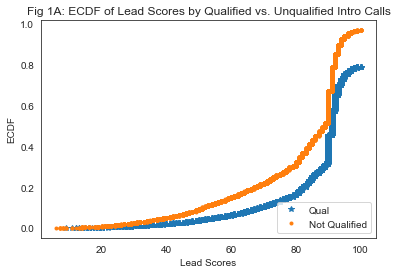

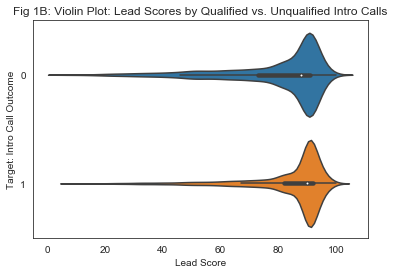

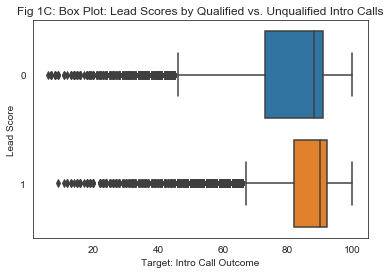

In [29]:
### Lead Score

closedWonIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1]
closedLostIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0]




normSample = np.random.normal(np.mean(closedIntroCalls_Data.inferScore___Lead_AddedInfo), np.std(closedIntroCalls_Data.inferScore___Lead_AddedInfo), size=100000)


print("Summary of Qualified Intro Calls: ", closedWonIntro[['inferScore___Lead_AddedInfo']].describe())
print("\n")
print("Summary of Not Qualified Intro Calls: ", closedLostIntro[['inferScore___Lead_AddedInfo']].describe())


# Compute ECDFs
x_qual, y_qual = ecdf(closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1].inferScore___Lead_AddedInfo)
x_notQual, y_notQual = ecdf(closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0].inferScore___Lead_AddedInfo)




# Plot all ECDFs on the same plot
_ = plt.plot(x_qual, y_qual, marker = '*', linestyle = 'none')
_ = plt.plot(x_notQual, y_notQual, marker = '.', linestyle = 'none')


# Annotate the plot
plt.legend(('Qual', 'Not Qualified'), loc='lower right')
_ = plt.xlabel('Lead Scores')
_ = plt.ylabel('ECDF')
_ = plt.title('Fig 1A: ECDF of Lead Scores by Qualified vs. Unqualified Intro Calls')

# Display the plot
plt.show()


# Create bee swarm plot
fig2 = sns.violinplot(x='inferScore___Lead_AddedInfo',y='Target___IntroCall_Outcome_map',data=closedIntroCalls_Data, scale='count',orient='h')

# Label the axes
fig2 = plt.xlabel('Lead Score')
fig2 = plt.ylabel('Target: Intro Call Outcome')
fig2 = plt.title('Fig 1B: Violin Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')

# Show the plot
plt.show()



# Create box plot with Seaborn's default settings
fig3 = sns.boxplot(y='Target___IntroCall_Outcome_map',x='inferScore___Lead_AddedInfo',data=closedIntroCalls_Data, orient='h')

# Label the axes
fig3 =plt.xlabel('Target: Intro Call Outcome')
fig3 =plt.ylabel('Lead Score')
fig3 = plt.title('Fig 1C: Box Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')


# Show the plot
plt.show()






I created charts showing the empirical cumulative distribution function (Fig 1A), the distribution of lead scores (Fig 1B), and a box-plot displaying the summary statistics (Fig 1C) in order to further understand the distributions of lead scores. 

> * [Fig 1A] We can see from the ECDF that both groups experience a pick up at Lead Score ~ 80, where a relatively larger proportion of prospects exist. However our sample of Disqualified Intro Calls shows a relatively higher proportion of leads between 40 and 90.
> * [Fig 1B] Each violin plot is scaled by count. We can see that the samples are roughly the same size, seem to have medians concentrated around ~90 (visually confirm the summary statistics we printed earlier), and both are left skewed. The Unqualified Lead Scores (Target Outcome = 0) sample also has a fatter peak and more observations in the 60 & below range (as shown by the fatter tail).     
> * [Fig 1C] We can see that the Unqualified Lead Scores potentially display higher variance and have lower lead scores at the 25%.   



Qualified Intro Calls (Lead Score):      inferScore___Lead_AddedInfo
6                          93.0
8                          88.0
9                          87.0
12                         75.0
13                         90.0
17                         88.0
20                         97.0
23                         92.0
25                         92.0
27                         90.0
28                         87.0
29                         90.0
32                         90.0
36                         94.0
37                         90.0
38                         89.0
41                         92.0
42                         90.0
44                         90.0
45                         82.0

 
 

Disqualified Intro Calls (Lead Score):      inferScore___Lead_AddedInfo
0                          90.0
1                          90.0
3                          54.0
4                          94.0
5                          80.0
7                          92.0
10                   

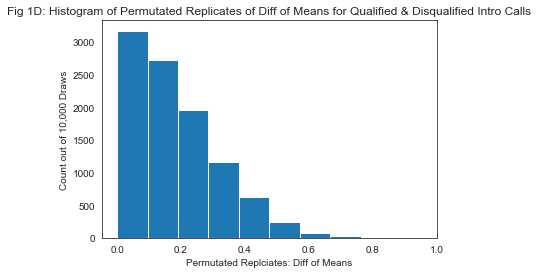


 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


In [30]:
# Hypothesis 1: Permutation Test - 
# Simulating the null hypothesis that the two variables have identical distributions
# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups
# If there is no measureable difference, then reshuffling of labels should be arbitrary

# p-value in this case is measuring the proportion of replicates that have as 
# big a value as the empirical diff (or greater)
# Statistically significant p-value is low
# i.e. whether it falls into the tails of the empirically derived sampling distribution 

# Compute difference of mean impact force from experiment: empirical_diff_means

force_a = closedWonIntro[['inferScore___Lead_AddedInfo']]
force_a = force_a.dropna()

force_b = closedLostIntro[['inferScore___Lead_AddedInfo']]
force_b = force_b.dropna()

print("Qualified Intro Calls (Lead Score): ", force_a.head(20))
print("\n \n \n")
print("Disqualified Intro Calls (Lead Score): ", force_b.head(20))

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

print("\n \n \n")
print("Empirical Diff of Mean:", empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates= draw_perm_reps(force_a, force_b, diff_of_means, size=10000)


print("\n")

fig4 = plt.hist(perm_replicates)
fig4 = plt.xlabel('Permutated Replciates: Diff of Means')
fig4 = plt.ylabel('Count out of 10,000 Draws')
fig4 = plt.title('Fig 1D: Histogram of Permutated Replicates of Diff of Means for Qualified & Disqualified Intro Calls')


plt.show()


# Compute p-value: p
p = len(perm_replicates[perm_replicates >= empirical_diff_means]) / len(perm_replicates)

# Print the result
print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)




#### First hypothesis: Permutation Test - Simulating the null hypothesis that Qualified and Unqualified Lead Scores have identical distributions even while the means differ. Alpha = 5%. Our goal is to understand how likely we would have calculated a difference of means as great or greater than the current value. 

Results:
> * Empirical Diff of Mean: 4.812948133518233
> * Proportion of replicates with value as great or greater than empirical diff of means p-value = 0.0000


The histogram of permuted replicates below shows how extreme a value of 4.8 is relative to expectation if the populations had been the same (Fig 1D).




Concatenated Qualified & Disqualified Data: [[93.]
 [88.]
 [87.]
 ...
 [92.]
 [90.]
 [83.]]


Mean Values of Concatenated Data:  81.82739465518966


Qualified Intro Call Shifted:      inferScore___Lead_AddedInfo
6                     90.635677
8                     85.635677
9                     84.635677
12                    72.635677
13                    87.635677
17                    85.635677
20                    94.635677
23                    89.635677
25                    89.635677
27                    87.635677


Disqualified Intro Call Shifted:      inferScore___Lead_AddedInfo
0                     92.448625
1                     92.448625
3                     56.448625
4                     96.448625
5                     82.448625
7                     94.448625
10                    92.448625
11                    87.448625
14                    87.448625
18                    92.448625


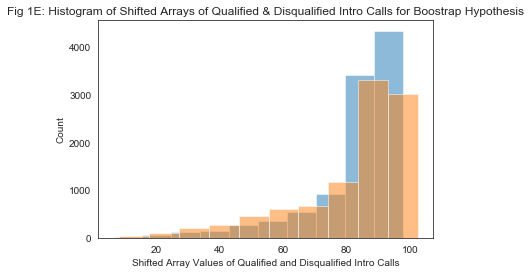


 

Qualified Intro Call Boostrap Replicates:  [81.75145525 81.92694217 81.95468169 ... 81.81745958 81.63961185
 81.65899017]


Disqualified Intro Call Boostrap Replicates:  [81.71370272 82.00272065 81.75200753 ... 81.50455439 82.24823818
 81.83136776]

 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


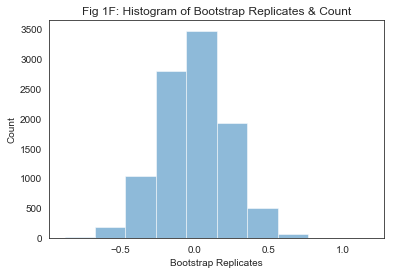

In [31]:
# Hypothesis 2: Two Sample Bootstrap Hypothesis Test for Differences of Means - 

# Simulating the null hypothesis that the two variables are the same 
# but belong to two different distributions. 
# Shift both arrays of data to have the same mean and generate boostrap replicates 
# (draw samples from shifted arrays & compute the difference in means)


# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups


# p-value in this case is measuring the proportion of replicates with a difference in means 
#greater than or equal to observed via the empirrical diff of means




# Compute mean of all forces: mean_force

forces_concat = pd.concat([force_a, force_b])
forces_concat = np.array(forces_concat)

print("\n")
print("Concatenated Qualified & Disqualified Data:", forces_concat)

mean_force = np.mean(forces_concat)
print("\n")
print("Mean Values of Concatenated Data: ", mean_force)


# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

print("\n")
print("Qualified Intro Call Shifted: ", force_a_shifted.head(10))
print("\n")
print("Disqualified Intro Call Shifted: ", force_b_shifted.head(10))

force_a_shifted = np.array(force_a_shifted)
force_b_shifted = np.array(force_b_shifted)

fig5 = plt.hist(force_a_shifted, alpha=0.5)
fig5 = plt.hist(force_b_shifted, alpha=0.5)

fig5 = plt.xlabel('Shifted Array Values of Qualified and Disqualified Intro Calls')
fig5 = plt.ylabel('Count')
fig5 = plt.title('Fig 1E: Histogram of Shifted Arrays of Qualified & Disqualified Intro Calls for Boostrap Hypothesis')


plt.show()

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

print("\n \n")
print("Qualified Intro Call Boostrap Replicates: ", bs_replicates_a)

print("\n")
print("Disqualified Intro Call Boostrap Replicates: ", bs_replicates_b)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)


print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

fig6 = plt.hist(bs_replicates, alpha=0.5)
fig6 = plt.xlabel('Bootstrap Replicates')
fig6 = plt.ylabel('Count')
fig6 = plt.title('Fig 1F: Histogram of Bootstrap Replicates & Count')

plt.show()

#### Second hypothesis: Bootstrap Test - Simulating the null hypothesis that Qualified and Unqualified Lead Scores have identical means but come from different populations. Alpha = 5%. Our goal is to understand how likely we would have calculated a difference of means as great or greater than the current value given the shifted arrays (Fig 1E).


Results:
> * Mean Values of Concatenated Data:  81.82739465518966
> * Empirical Diff of Mean: 4.812948133518233y
> * Proportion of replicates with value as great or greater than empirical diff of means p-value = 0.0000

The histogram of bootstrap replicates below shows how extreme a value of 4.8 is relative to expectation if the populations had been the same (Fig 1F).



In [32]:
#Using Mann-Whitney Test & Wlech's t-test

print(stats.mannwhitneyu(force_a, force_b))

print(stats.ttest_ind(force_a, force_b, equal_var = False))

MannwhitneyuResult(statistic=40960991.0, pvalue=1.2447515478111441e-107)
Ttest_indResult(statistic=array([21.26104234]), pvalue=array([3.89798532e-99]))


Both the Mann-Whitney test and Welch’s T-Test seem to also support rejecting the null hypothesis that the means are the same. 

## Analysis 2: Total Calls & Emails vs Target Outcome

* The first step in analyzing the possible relationship between Total Calls & Emails on Target outcome is to examine the summary statistics and note differences in mean, median, min/max, In an ideal sales world, most sales managers would like sales reps to engage in the minimum amount of correspondence needed to: (1) qualify a prospect and (2) ensure good prospects are pulled into the sales process.  

> * From printing the summary statistics, we can already see that Disqualified Intro Calls were associated with a higher mean of Total Calls & Emails compared to Qualified Intro Calls (36.9 vs. 28.0). 
> * We can also see a difference in the IQR of Disqualified vs Qualified Intro Calls, indicating that prospects of Disqualified Intro Calls could be taking up more sales rep time (Qualified: [12 (25%), 40 (75%)], Disqualified: [14 (25%), 52 (75%)]). ] 


Qualified:         totalCallsEmails
count       6953.000000
mean          28.003452
std           21.391253
min            0.000000
25%           12.000000
50%           24.000000
75%           40.000000
max          100.000000


Not Qualified:         totalCallsEmails
count       6870.000000
mean          36.900728
std           29.253542
min            0.000000
25%           14.000000
50%           30.000000
75%           52.000000
max          138.000000


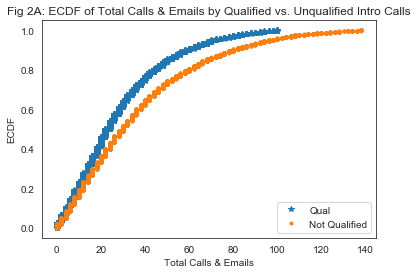

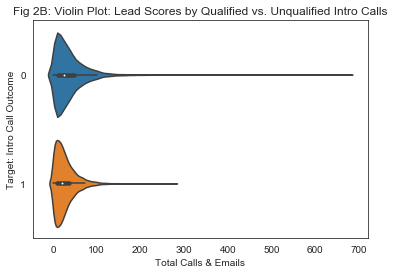

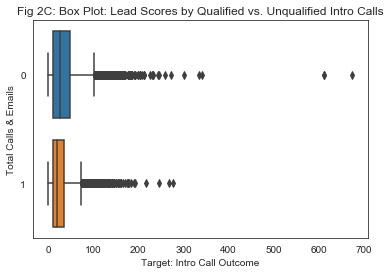

In [33]:
### Total Calls Emails

closedWonIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1]
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.totalCallsEmails-closedWonIntro.totalCallsEmails.mean()) <= (3*closedWonIntro.totalCallsEmails.std())]
closedWonIntro = closedWonIntro[closedWonIntro['introCallCreated_leadCreated_delta']>0]

closedLostIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0]
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.totalCallsEmails-closedLostIntro.totalCallsEmails.mean()) <= (3*closedLostIntro.totalCallsEmails.std())]
closedLostIntro = closedLostIntro[closedLostIntro['introCallCreated_leadCreated_delta']>0]



print("Qualified: ", closedWonIntro[['totalCallsEmails']].describe())
print("\n")
print("Not Qualified: ", closedLostIntro[['totalCallsEmails']].describe())


# Compute ECDFs
x_qual, y_qual = ecdf(closedWonIntro.totalCallsEmails)
x_notQual, y_notQual = ecdf(closedLostIntro.totalCallsEmails)




# Plot all ECDFs on the same plot
_ = plt.plot(x_qual, y_qual, marker = '*', linestyle = 'none')
_ = plt.plot(x_notQual, y_notQual, marker = '.', linestyle = 'none')


# Annotate the plot
plt.legend(('Qual', 'Not Qualified'), loc='lower right')
_ = plt.xlabel('Total Calls & Emails')
_ = plt.ylabel('ECDF')
_ = plt.title('Fig 2A: ECDF of Total Calls & Emails by Qualified vs. Unqualified Intro Calls')

# Display the plot
plt.show()


# Create bee swarm plot
fig2 = sns.violinplot(x='totalCallsEmails',y='Target___IntroCall_Outcome_map',data=closedIntroCalls_Data, scale='count',orient='h')

# Label the axes
fig2 = plt.xlabel('Total Calls & Emails')
fig2 = plt.ylabel('Target: Intro Call Outcome')
fig2 = plt.title('Fig 2B: Violin Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')

# Show the plot
plt.show()



# Create box plot with Seaborn's default settings
fig3 = sns.boxplot(y='Target___IntroCall_Outcome_map',x='totalCallsEmails',data=closedIntroCalls_Data, orient='h')

# Label the axes
fig3 =plt.xlabel('Target: Intro Call Outcome')
fig3 =plt.ylabel('Total Calls & Emails')
fig3 = plt.title('Fig 2C: Box Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')


# Show the plot
plt.show()


* Similarly to Analysis Part 1, I visually examine the sample distributions further.

> * [Fig 2A] Looking at the ECDF’s we can see that 60% of Qualified Intro Calls were associated with =<~30 Total Calls & Emails while the same % of Disqualified Intro Calls were associated with  =< ~40 Total Calls & Emails.
> * [Fig 2B] Another trend we can observe (from both the violin plot and the summary statistics printout) is the presence of significant outliers in the Disqualified sample of Total Calls & Emails.       	    
> * [Fig 2C] We can also verify in the boxplot the wider IQR, mostly due to the 75 percentile of data being shifted to the right (i.e. towards higher Total Calls & Emails) with two incredibly extreme outliers (~600+ Emails & Calls!)


Qualified Intro Calls (Total Calls Emails):      totalCallsEmails
6               12.0
8               80.0
9               88.0
12              82.0
17              40.0
20              16.0
23              20.0
25              22.0
27              36.0
28              24.0
29              34.0
32              50.0
37              44.0
38              18.0
42              16.0
44              58.0
45              70.0
48              26.0
50              54.0
53              24.0

 
 

Disqualified Intro Calls (Total Calls Emails):      totalCallsEmails
0               20.0
1               18.0
3              136.0
5               30.0
7               64.0
11              52.0
14              60.0
18              44.0
21              46.0
22              10.0
24              28.0
26              52.0
30              60.0
31              10.0
33              24.0
35              78.0
40              10.0
46              48.0
49             138.0
51              76.0

 
 

Empirical Dif

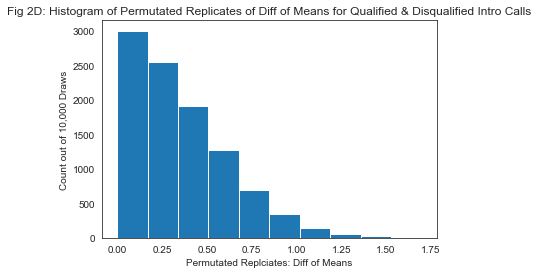


 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


In [34]:
# Hypothesis 1: Permutation Test - 
# Simulating the null hypothesis that the two variables have identical distributions
# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups
# If there is no measureable difference, then reshuffling of labels should be arbitrary

# p-value in this case is measuring the proportion of replicates that have as 
# big a value as the empirical diff (or greater)
# Statistically significant p-value is low
# i.e. whether it falls into the tails of the empirically derived sampling distribution 

# Compute difference of mean impact force from experiment: empirical_diff_means

force_a = closedWonIntro[['totalCallsEmails']]
force_a = force_a.dropna()

force_b = closedLostIntro[['totalCallsEmails']]
force_b = force_b.dropna()

print("Qualified Intro Calls (Total Calls Emails): ", force_a.head(20))
print("\n \n \n")
print("Disqualified Intro Calls (Total Calls Emails): ", force_b.head(20))

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

print("\n \n \n")
print("Empirical Diff of Mean:", empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates= draw_perm_reps(force_a, force_b, diff_of_means, size=10000)


print("\n")

fig4 = plt.hist(perm_replicates)
fig4 = plt.xlabel('Permutated Replciates: Diff of Means')
fig4 = plt.ylabel('Count out of 10,000 Draws')
fig4 = plt.title('Fig 2D: Histogram of Permutated Replicates of Diff of Means for Qualified & Disqualified Intro Calls')


plt.show()


# Compute p-value: p
p = len(perm_replicates[perm_replicates >= empirical_diff_means]) / len(perm_replicates)

# Print the result
print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

* First hypothesis: 
> * Permutation Test - Simulating the null hypothesis that Qualified and Unqualified Total Calls & Emails have identical distributions even while the means differ. Alpha = 5%. Our goal is to understand how likely we would have calculated a difference of means as great or greater than the current value. 

Results:
> * Empirical Diff of Mean: 8.897276054590698
> * Proportion of replicates with value as great or greater than empirical diff of means p-value = 0.0000

The histogram of permuted replicates below shows how extreme a value of 9.0 is relative to expectation if the populations had been the same (Fig 2D).




Concatenated Qualified & Disqualified Data: [[ 12.]
 [ 80.]
 [ 88.]
 ...
 [126.]
 [ 46.]
 [ 50.]]


Mean Values of Concatenated Data:  32.42537799319974


Qualified Intro Call Shifted:      totalCallsEmails
6          16.421926
8          84.421926
9          92.421926
12         86.421926
17         44.421926
20         20.421926
23         24.421926
25         26.421926
27         40.421926
28         28.421926


Disqualified Intro Call Shifted:      totalCallsEmails
0           15.52465
1           13.52465
3          131.52465
5           25.52465
7           59.52465
11          47.52465
14          55.52465
18          39.52465
21          41.52465
22           5.52465


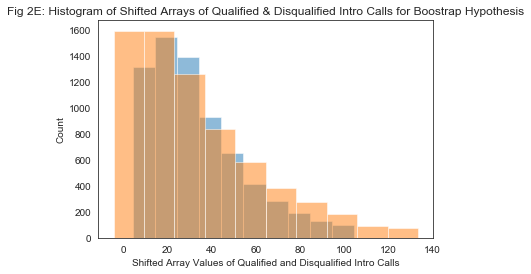


 

Qualified Intro Call Boostrap Replicates:  [32.59911595 32.54072389 32.3396596  ... 32.36267125 32.78579796
 32.44982787]


Disqualified Intro Call Boostrap Replicates:  [32.80674626 32.40994859 32.45536344 ... 32.59713927 31.74386416
 32.00791074]

 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


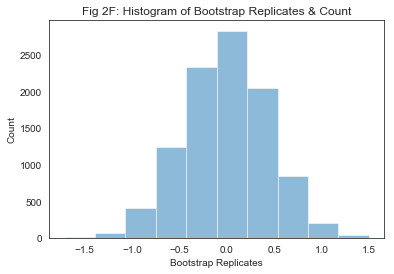

In [35]:
# Hypothesis 2: Two Sample Bootstrap Hypothesis Test for Differences of Means - 

# Simulating the null hypothesis that the two variables are the same 
# but belong to two different distributions. 
# Shift both arrays of data to have the same mean and generate boostrap replicates 
# (draw samples from shifted arrays & compute the difference in means)


# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups


# p-value in this case is measuring the proportion of replicates with a difference in means 
#greater than or equal to observed via the empirrical diff of means




# Compute mean of all forces: mean_force

forces_concat = pd.concat([force_a, force_b])
forces_concat = np.array(forces_concat)

print("\n")
print("Concatenated Qualified & Disqualified Data:", forces_concat)

mean_force = np.mean(forces_concat)
print("\n")
print("Mean Values of Concatenated Data: ", mean_force)


# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

print("\n")
print("Qualified Intro Call Shifted: ", force_a_shifted.head(10))
print("\n")
print("Disqualified Intro Call Shifted: ", force_b_shifted.head(10))

force_a_shifted = np.array(force_a_shifted)
force_b_shifted = np.array(force_b_shifted)

fig5 = plt.hist(force_a_shifted, alpha=0.5)
fig5 = plt.hist(force_b_shifted, alpha=0.5)

fig5 = plt.xlabel('Shifted Array Values of Qualified and Disqualified Intro Calls')
fig5 = plt.ylabel('Count')
fig5 = plt.title('Fig 2E: Histogram of Shifted Arrays of Qualified & Disqualified Intro Calls for Boostrap Hypothesis')


plt.show()

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

print("\n \n")
print("Qualified Intro Call Boostrap Replicates: ", bs_replicates_a)

print("\n")
print("Disqualified Intro Call Boostrap Replicates: ", bs_replicates_b)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)


print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

fig6 = plt.hist(bs_replicates, alpha=0.5)
fig6 = plt.xlabel('Bootstrap Replicates')
fig6 = plt.ylabel('Count')
fig6 = plt.title('Fig 2F: Histogram of Bootstrap Replicates & Count')

plt.show()

* Second hypothesis: Bootstrap Test - Simulating the null hypothesis that Qualified and Unqualified Total Calls/Emails have identical means but come from different populations. Alpha = 5%. Our goal is to understand how likely we would have calculated a difference of means as great or greater than the current value given the shifted arrays (Fig 2E). 

Results:
> * Mean Values of Concatenated Data:  32.42537799319974
> * Empirical Diff of Mean: 8.897276054590698
> * Proportion of replicates with value as great or greater than empirical diff of means p-value = 0.0000

The histogram of bootstrap replicates below shows how extreme a value of 9.0 is relative to expectation if the populations had been the same (Fig 2F).


In [36]:
#Using Mann-Whitney Test & Wlech's t-test

print(stats.mannwhitneyu(force_a, force_b))

print(stats.ttest_ind(force_a, force_b, equal_var = False))

MannwhitneyuResult(statistic=20132210.0, pvalue=6.468704474691752e-58)
Ttest_indResult(statistic=array([-20.39150626]), pvalue=array([5.83924509e-91]))


Both the Mann-Whitney test and Welch’s T-Test seem to also support rejecting the null hypothesis that the means are the same.


## Analysis 3: Lead-Intro Call Delta vs Target Outcome

* As written previously, lead freshness is an important concept in sales and we could expect to see Disqualified Intro Calls associated with higher Time Deltas. 
> *  On average however, Qualified Intro Calls have higher means (39 days) than Disqualified Intro Calls (30 days). 



Qualified:         introCallCreated_leadCreated_delta
count                         8938.000000
mean                            30.622734
std                             62.353438
min                              1.000000
25%                              2.000000
50%                              7.000000
75%                             25.000000
max                            420.000000


Not Qualified:         introCallCreated_leadCreated_delta
count                         7507.000000
mean                            29.170108
std                             56.099237
min                              1.000000
25%                              3.000000
50%                              8.000000
75%                             28.000000
max                            390.000000


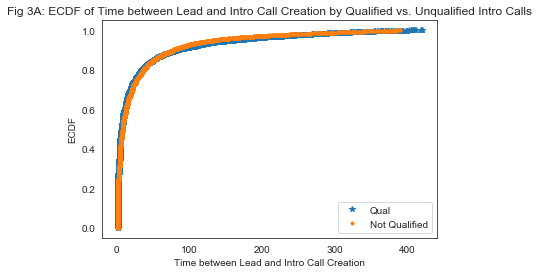

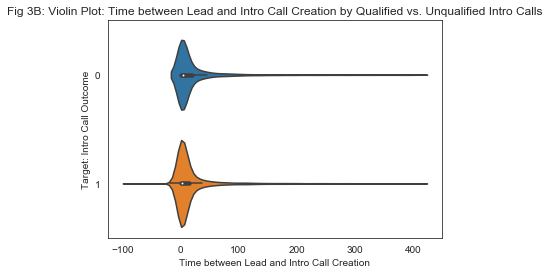

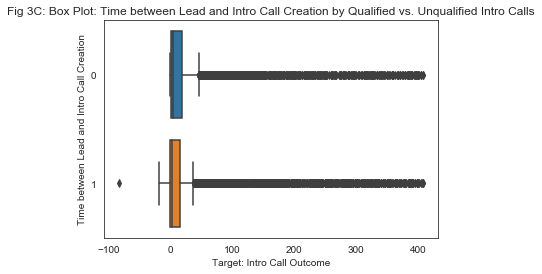

In [37]:
### Lead Created Delta

closedWonIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1]
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.introCallCreated_leadCreated_delta-closedWonIntro.introCallCreated_leadCreated_delta.mean()) <= (3*closedWonIntro.introCallCreated_leadCreated_delta.std())]
closedWonIntro = closedWonIntro[closedWonIntro['introCallCreated_leadCreated_delta']>0]

closedLostIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0]
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.introCallCreated_leadCreated_delta-closedLostIntro.introCallCreated_leadCreated_delta.mean()) <= (3*closedLostIntro.introCallCreated_leadCreated_delta.std())]
closedLostIntro = closedLostIntro[closedLostIntro['introCallCreated_leadCreated_delta']>0]

closedIntroCalls_Data = closedIntroCalls_Data[np.abs(closedIntroCalls_Data.introCallCreated_leadCreated_delta-closedIntroCalls_Data.introCallCreated_leadCreated_delta.mean()) <= (3*closedIntroCalls_Data.introCallCreated_leadCreated_delta.std())]

print("Qualified: ", closedWonIntro[['introCallCreated_leadCreated_delta']].describe())
print("\n")
print("Not Qualified: ", closedLostIntro[['introCallCreated_leadCreated_delta']].describe())


# Compute ECDFs
x_qual, y_qual = ecdf(closedWonIntro.introCallCreated_leadCreated_delta)
x_notQual, y_notQual = ecdf(closedLostIntro.introCallCreated_leadCreated_delta)


# Plot all ECDFs on the same plot
_ = plt.plot(x_qual, y_qual, marker = '*', linestyle = 'none')
_ = plt.plot(x_notQual, y_notQual, marker = '.', linestyle = 'none')



# Annotate the plot
plt.legend(('Qual', 'Not Qualified'), loc='lower right')
_ = plt.xlabel('Time between Lead and Intro Call Creation')
_ = plt.ylabel('ECDF')
_ = plt.title('Fig 3A: ECDF of Time between Lead and Intro Call Creation by Qualified vs. Unqualified Intro Calls')

# Display the plot
plt.show()


# Create bee swarm plot
fig2 = sns.violinplot(x='introCallCreated_leadCreated_delta',y='Target___IntroCall_Outcome_map',data=closedIntroCalls_Data, scale='count',orient='h')

# Label the axes
fig2 = plt.xlabel('Time between Lead and Intro Call Creation')
fig2 = plt.ylabel('Target: Intro Call Outcome')
fig2 = plt.title('Fig 3B: Violin Plot: Time between Lead and Intro Call Creation by Qualified vs. Unqualified Intro Calls')

# Show the plot
plt.show()



# Create box plot with Seaborn's default settings
fig3 = sns.boxplot(y='Target___IntroCall_Outcome_map',x='introCallCreated_leadCreated_delta',data=closedIntroCalls_Data, orient='h')

# Label the axes
fig3 =plt.xlabel('Target: Intro Call Outcome')
fig3 =plt.ylabel('Time between Lead and Intro Call Creation')
fig3 = plt.title('Fig 3C: Box Plot: Time between Lead and Intro Call Creation by Qualified vs. Unqualified Intro Calls')


# Show the plot
plt.show()


* We can also observe some interesting characteristics about the data with regards to the Time Delta of Lead Created to Intro Call Created. 
> * [Fig 3A] The ECDF’s are very similar giving the first indication that there might not be significant differences between Disqualified and Qualified Intro Calls with regards to the Time Delta. 
> * [Fig 3B] We do see however that there are potentially some negative values that could be impacting the mean.   
> * [Fig 3C]  For both groups, we notice there are a number of outliers for both Qualified and Disqualified Intro Calls. Qualified Intro Calls also has some strangely negative values which may need to be excluded. 


Qualified Intro Calls (Time Duration of Lead to Intro call Created):      introCallCreated_leadCreated_delta
6                                  1.0
8                                 29.0
9                                119.0
12                                58.0
17                                 1.0
20                                 5.0
23                                 3.0
25                                14.0
27                                 7.0
28                                 5.0
29                                 1.0
32                                10.0
37                                 5.0
38                               317.0
42                                23.0
44                                22.0
45                                50.0
48                                 2.0
50                                 6.0
53                               124.0

 
 

Disqualified Intro Calls (Time Duration of Lead to Intro call Created):      introCallCreated_leadCreated

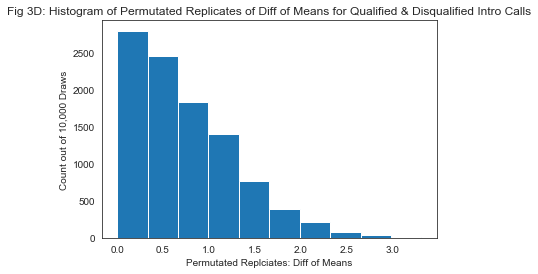


 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.1170


In [38]:
# Hypothesis 1: Permutation Test - 
# Simulating the null hypothesis that the two variables have identical distributions
# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups
# If there is no measureable difference, then reshuffling of labels should be arbitrary

# p-value in this case is measuring the proportion of replicates that have as 
# big a value as the empirical diff (or greater)
# Statistically significant p-value is low
# i.e. whether it falls into the tails of the empirically derived sampling distribution 

# Compute difference of mean impact force from experiment: empirical_diff_means

force_a = closedWonIntro[['introCallCreated_leadCreated_delta']]
force_a = force_a.dropna()

force_b = closedLostIntro[['introCallCreated_leadCreated_delta']]
force_b = force_b.dropna()

print("Qualified Intro Calls (Time Duration of Lead to Intro call Created): ", force_a.head(20))
print("\n \n \n")
print("Disqualified Intro Calls (Time Duration of Lead to Intro call Created): ", force_b.head(20))

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

print("\n \n \n")
print("Empirical Diff of Mean:", empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates= draw_perm_reps(force_a, force_b, diff_of_means, size=10000)


print("\n")

fig4 = plt.hist(perm_replicates)
fig4 = plt.xlabel('Permutated Replciates: Diff of Means')
fig4 = plt.ylabel('Count out of 10,000 Draws')
fig4 = plt.title('Fig 3D: Histogram of Permutated Replicates of Diff of Means for Qualified & Disqualified Intro Calls')


plt.show()


# Compute p-value: p
p = len(perm_replicates[perm_replicates >= empirical_diff_means]) / len(perm_replicates)

# Print the result
print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

* First hypothesis: Permutation Test - Simulating the null hypothesis that Qualified and Unqualified Lead Scores have identical distributions even while the means differ. Alpha = 5%. Our goal is to understand how likely we would have calculated a difference of means as great or greater than the current value. 


* Results:
> * Empirical Diff of Mean: 1.452626493187548
> * Proportion of replicates with value as great or greater than empirical diff of means p-value = 0.1170
> * From the histogram of permuted replicates we can visually see that the empirical mean of 1.5 isn’t an extreme value with about 12% of the permuted values having a value as great or greater than the empirical difference of means. The permutation test result doesn’t seem to provide evidence to reject the null hypothesis that Qualified and Disqualified Intro Calls are significantly different with regards to the Time Delta(Fig 3D).




Concatenated Qualified & Disqualified Data: [[  1.]
 [ 29.]
 [119.]
 ...
 [ 91.]
 [ 26.]
 [ 58.]]


Mean Values of Concatenated Data:  29.95962298570994


Qualified Intro Call Shifted:      introCallCreated_leadCreated_delta
6                             0.336889
8                            28.336889
9                           118.336889
12                           57.336889
17                            0.336889
20                            4.336889
23                            2.336889
25                           13.336889
27                            6.336889
28                            4.336889


Disqualified Intro Call Shifted:      introCallCreated_leadCreated_delta
0                             6.789515
1                             5.789515
3                            77.789515
7                            48.789515
11                           30.789515
14                           35.789515
18                            1.789515
21                           44.789

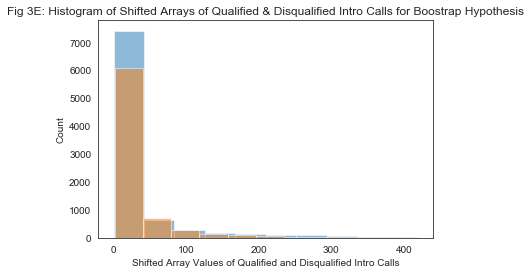


 

Qualified Intro Call Boostrap Replicates:  [29.88208886 29.81909938 30.22702061 ... 29.37515219 29.6438924
 29.97349634]


Disqualified Intro Call Boostrap Replicates:  [29.7912468  29.71838148 29.7364979  ... 30.52882506 29.49432393
 31.02995734]

 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0588


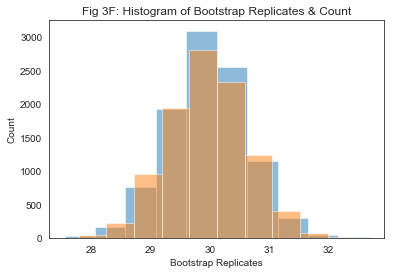

In [39]:
# Hypothesis 2: Two Sample Bootstrap Hypothesis Test for Differences of Means - 

# Simulating the null hypothesis that the two variables are the same 
# but belong to two different distributions. 
# Shift both arrays of data to have the same mean and generate boostrap replicates 
# (draw samples from shifted arrays & compute the difference in means)


# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups


# p-value in this case is measuring the proportion of replicates with a difference in means 
#greater than or equal to observed via the empirrical diff of means




# Compute mean of all forces: mean_force

forces_concat = pd.concat([force_a, force_b])
forces_concat = np.array(forces_concat)

print("\n")
print("Concatenated Qualified & Disqualified Data:", forces_concat)

mean_force = np.mean(forces_concat)
print("\n")
print("Mean Values of Concatenated Data: ", mean_force)


# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

print("\n")
print("Qualified Intro Call Shifted: ", force_a_shifted.head(10))
print("\n")
print("Disqualified Intro Call Shifted: ", force_b_shifted.head(10))

force_a_shifted = np.array(force_a_shifted)
force_b_shifted = np.array(force_b_shifted)

fig5 = plt.hist(force_a_shifted, alpha=0.5)
fig5 = plt.hist(force_b_shifted, alpha=0.5)

fig5 = plt.xlabel('Shifted Array Values of Qualified and Disqualified Intro Calls')
fig5 = plt.ylabel('Count')
fig5 = plt.title('Fig 3E: Histogram of Shifted Arrays of Qualified & Disqualified Intro Calls for Boostrap Hypothesis')


plt.show()

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

print("\n \n")
print("Qualified Intro Call Boostrap Replicates: ", bs_replicates_a)

print("\n")
print("Disqualified Intro Call Boostrap Replicates: ", bs_replicates_b)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)


print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

fig6 = plt.hist(bs_replicates_a, alpha=0.5)
fig6 = plt.hist(bs_replicates_b, alpha=0.5)
fig6 = plt.xlabel('Bootstrap Replicates')
fig6 = plt.ylabel('Count')
fig6 = plt.title('Fig 3F: Histogram of Bootstrap Replicates & Count')

plt.show()

* Second hypothesis: Bootstrap Test - Simulating the null hypothesis that Qualified and Unqualified Lead Scores have identical means but come from different populations. Alpha = 5%. Our goal is to understand how likely we would have calculated a difference of means as great or greater than the current value given the shifted arrays (Fig 1E). 


Results:
> * Mean Values of Concatenated Data:  29.95962298570994
> * Empirical Diff of Mean: 1.452626493187548
> * Proportion of replicates with value as great or greater than empirical diff of means p-value = 0.0588

Similarly the Bootstrap test isn’t significant at the 5% level, with ~5.9% of the bootstrap replicates exhibiting a value equal to or greater than the empirical difference of means.  (Fig 3F).


In [40]:
#Using Mann-Whitney Test & Wlech's t-test

print(stats.mannwhitneyu(force_a, force_b))

print(stats.ttest_ind(force_a, force_b, equal_var = False))

MannwhitneyuResult(statistic=32321837.5, pvalue=2.4385713413183856e-05)
Ttest_indResult(statistic=array([1.5717012]), pvalue=array([0.1160392]))


We are seeing conflicted results from the Mann-Whitney test (which seems to reject the null hypothesis that the populations are similar) and Welch’s T-Test (which doesn’t result in a statistically significant p-value).